In [15]:
import numpy
import scipy.special
from matplotlib import pyplot

pyplot.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

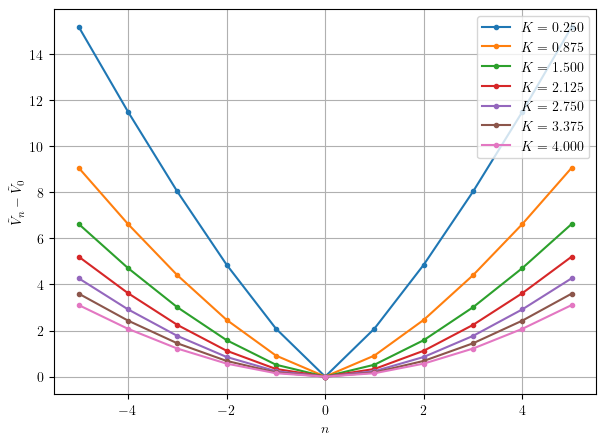

In [38]:
fig, ax = pyplot.subplots(figsize=(7,5))

for k in numpy.linspace(0.25,4,7):
    xs = numpy.arange(-5,5+1)
    offset = scipy.special.iv(0, k)
    pyplot.plot(xs, numpy.log(offset/scipy.special.iv(xs, k)), '.-', label=f"$K={k:.3f}$")
ax.grid()
ax.legend(loc="upper right")
ax.set_xlabel("$n$")
ax.set_ylabel(r"$\tilde{V}_{n} - \tilde{V}_0$")
pyplot.savefig("/tmp/cosine.pdf")
pyplot.show()